# Exploratory Data Analysys

## Exploring the images

In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

# System 
import os
import sys
sys.path.append('..')


# Self-made libraries
from utils import bboxes
from utils import util_funcs as uf

# Reload to pick last changes
import importlib
%load_ext autoreload
%autoreload 2

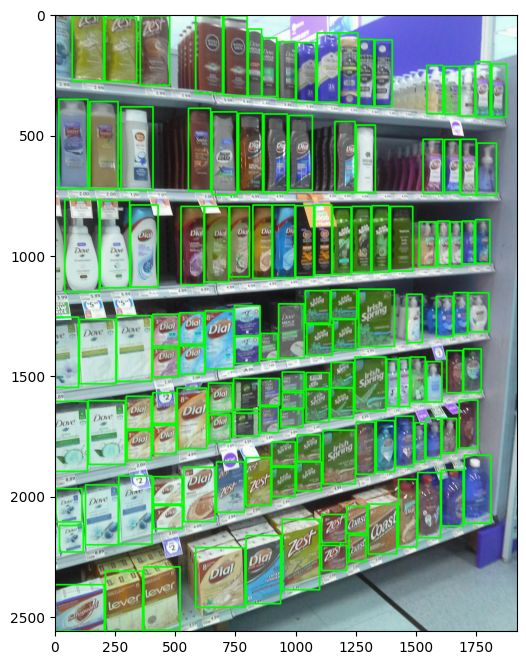

In [6]:
%matplotlib inline
fig,ax = plt.subplots(figsize = (12,8))
img0 = bboxes.get_bboxes('train_1.jpg')

## Failed images

#### Number-of-BBoxes-based analysis

First, we read all annotations in a DataFrame

In [4]:
tags_df = pd.DataFrame()

# Reading in chunks
for chunk_df in uf.read_csv_chunks(chunksize=50000):
    tags_df = pd.concat( [tags_df,chunk_df] , ignore_index = True)

tags_df.set_index('img_name',inplace = True)
tags_df

x1    y1    x2    y2    type  total_height  total_width
img_name                                                                
train_0.jpg     208   537   422   814  object          3024         3024
train_0.jpg    1268  1923  1365  2209  object          3024         3024
train_0.jpg    1135  2074  1261  2166  object          3024         3024
train_0.jpg    1045  2085  1122  2258  object          3024         3024
train_0.jpg     976  2036  1040  2177  object          3024         3024
...             ...   ...   ...   ...     ...           ...          ...
train_999.jpg   422  2386   675  2542  object          2336         4160
train_999.jpg   427  2581   667  2715  object          2336         4160
train_999.jpg   699  2365   823  2474  object          2336         4160
train_999.jpg  1849  1678  2108  1769  object          2336         4160
train_999.jpg   905  1589  1144  1712  object          2336         4160

[1208482 rows x 7 columns]

Let's see the distribution of number of bboxes per images

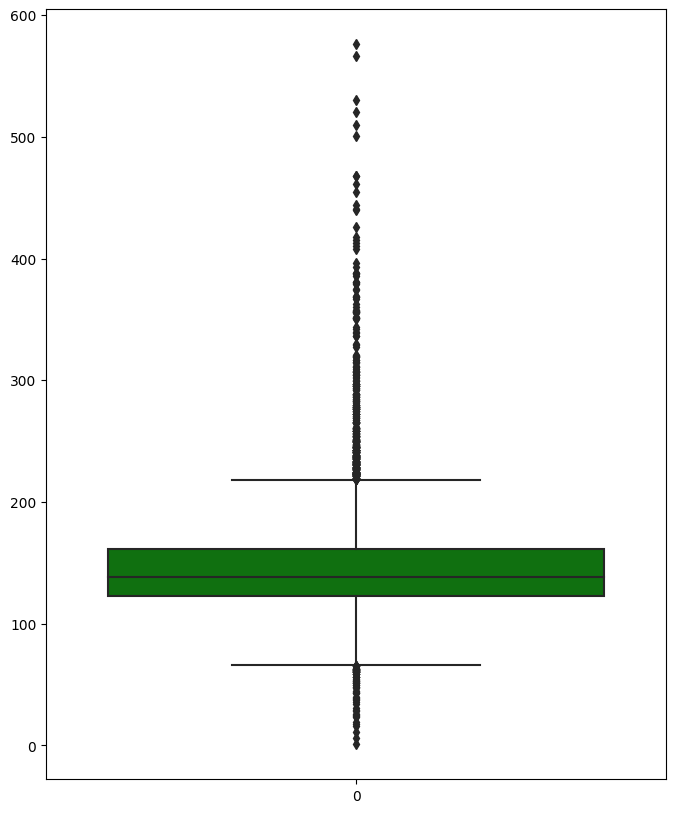

In [84]:
bbox_per_image = tags_df.groupby('img_name').size()
ax, fix = plt.subplots(1,1,figsize = (8,10))
_ = sns.boxplot(bbox_per_image, color = 'g')

Count the number of 'failed images' i.e. images a lot of missing bounding boxes

In [4]:
# Count images with less that `TAG_THRESH` tags
N_BBOX_THRESH = 60

failed_imgs1 = uf.get_failed_imgs(tags_df, criterion='n_bboxes', thresh= N_BBOX_THRESH, verbose = True)


Number of failed images:  44
List of failed images:
img_name
train_3029.jpg     1
train_6566.jpg     6
train_3622.jpg    11
train_2555.jpg    16
train_6216.jpg    18
train_7880.jpg    19
train_6477.jpg    23
train_6107.jpg    24
train_7716.jpg    25
train_7259.jpg    26
train_5842.jpg    28
train_85.jpg      29
train_701.jpg     31
train_7082.jpg    34
train_1296.jpg    36
train_1172.jpg    37
train_6138.jpg    38
train_7352.jpg    39
train_7584.jpg    40
train_68.jpg      43
train_5131.jpg    43
train_104.jpg     44
train_3983.jpg    45
train_2194.jpg    47
train_1724.jpg    48
train_890.jpg     48
train_5663.jpg    50
train_7487.jpg    50
train_2002.jpg    51
train_6268.jpg    51
train_126.jpg     51
train_3758.jpg    52
train_3530.jpg    53
train_3339.jpg    53
train_7545.jpg    54
train_496.jpg     55
train_6498.jpg    56
train_5815.jpg    56
train_4899.jpg    56
train_1769.jpg    56
train_7256.jpg    59
train_3874.jpg    59
train_480.jpg     59
train_8016.jpg    59
dtype: int64

T

We plot some of the 'failed' images to see the missing bboxes

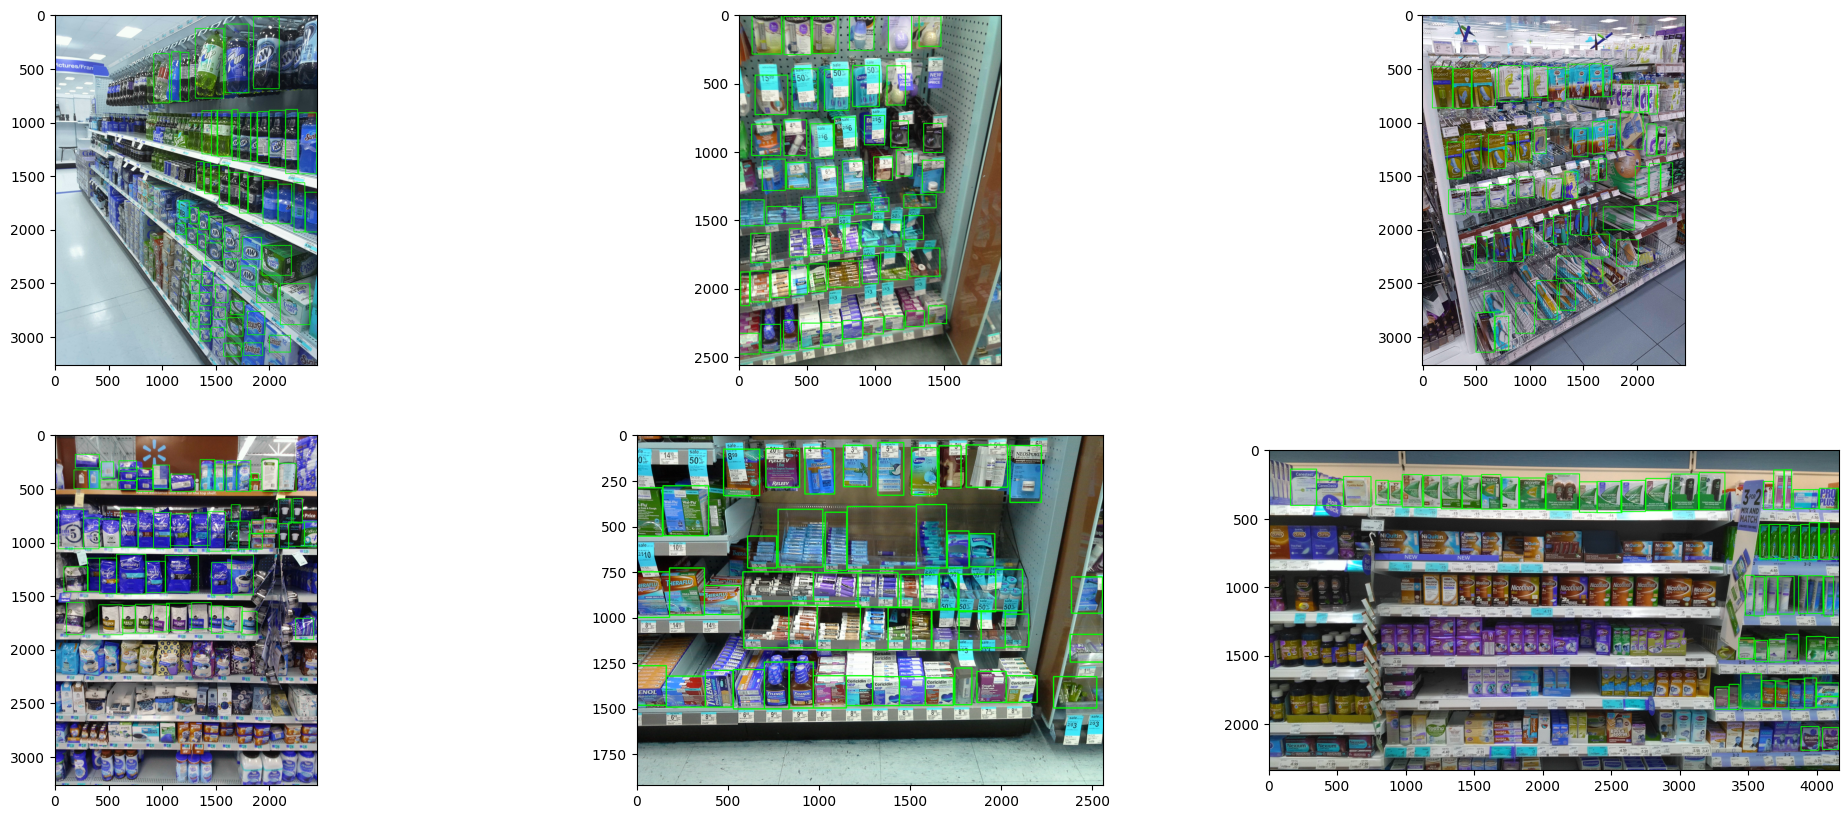

In [5]:

# Number of row and colums in the plot
r = 2 ; c = 3 

def plot_failed_imgs(failed_tags,r,c):
    
    if not len(failed_tags): return None
    _,axis = plt.subplots(r,c,figsize = (25,10))

    for r,ax_list in enumerate(axis):
        for x,ax in enumerate(ax_list):
            idx = x+1+r*c
            _ = bboxes.get_bboxes(img_name= failed_tags.index[-idx], axes= ax)

plot_failed_imgs(failed_imgs1,r,c)    

> _At this point we realized that there could be good images with a low number of bounding boxes._

> **If you observe well, you can notice that 'failed images' are actually to be determined based on the percentage of area that all bounding boxes cover, not on the number of total bounding boxes !!**

> Let's try to use approch to find 'failed images' as images where the bboxes cover a low % of the image

#### Total-Area-based analysis

In [9]:
areas_df = bboxes.get_bboxes_total_area(tags_df)
areas_df

total_area  bbox_area  bbox_area_perc
img_name                                            
train_0.jpg       9144576      59278        0.006482
train_0.jpg       9144576      27742        0.003034
train_0.jpg       9144576      11592        0.001268
train_0.jpg       9144576      13321        0.001457
train_0.jpg       9144576       9024        0.000987
...                   ...        ...             ...
train_999.jpg     9717760      39468        0.004061
train_999.jpg     9717760      32160        0.003309
train_999.jpg     9717760      13516        0.001391
train_999.jpg     9717760      23569        0.002425
train_999.jpg     9717760      29397        0.003025

[1208482 rows x 3 columns]

We get the % of area covered by the bounding boxes

In [10]:
bbox_area_cover = areas_df.groupby('img_name').bbox_area_perc.sum().sort_values()
bbox_area_cover

img_name
train_3029.jpg    0.006115
train_6566.jpg    0.025378
train_3622.jpg    0.049998
train_6216.jpg    0.053780
train_693.jpg     0.054528
                    ...   
train_7130.jpg    0.736432
train_3456.jpg    0.739458
train_6117.jpg    0.746425
train_5101.jpg    0.747696
train_1557.jpg    0.757186
Name: bbox_area_perc, Length: 8219, dtype: float64

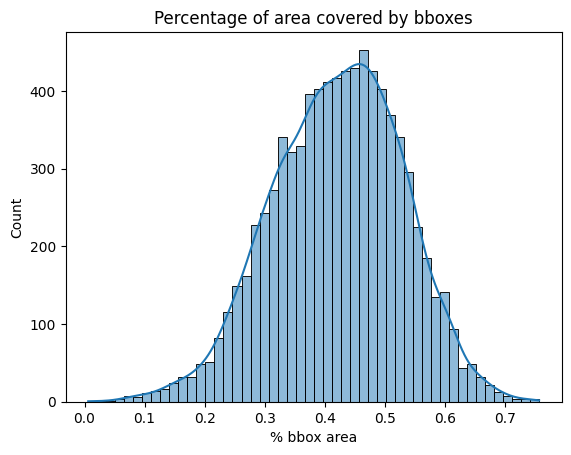

In [11]:
import seaborn as sns

ax = sns.histplot(bbox_area_cover, kde = True )
ax.set_title('Percentage of area covered by bboxes')
_ = ax.set(xlabel = '% bbox area')

We defined the threshold as a quantile from the histogram above, for which we will be consider that the tagging has failed i.e. the minimum area that the bboxes have to cover in order to be considered as a valid tagged image for training

In [12]:
quantile = 0.01
failed_tags_area = uf.get_failed_imgs(tags_df, criterion = 'area', thresh = quantile)
failed_tags_area

Treshold used: 0.15426383982923236
# failed images:  83


img_name
train_3029.jpg    0.006115
train_6566.jpg    0.025378
train_3622.jpg    0.049998
train_6216.jpg    0.053780
train_693.jpg     0.054528
                    ...   
train_2961.jpg    0.152320
train_4101.jpg    0.152860
train_1296.jpg    0.153243
train_6752.jpg    0.153723
train_7164.jpg    0.154225
Name: bbox_area_perc, Length: 83, dtype: float64

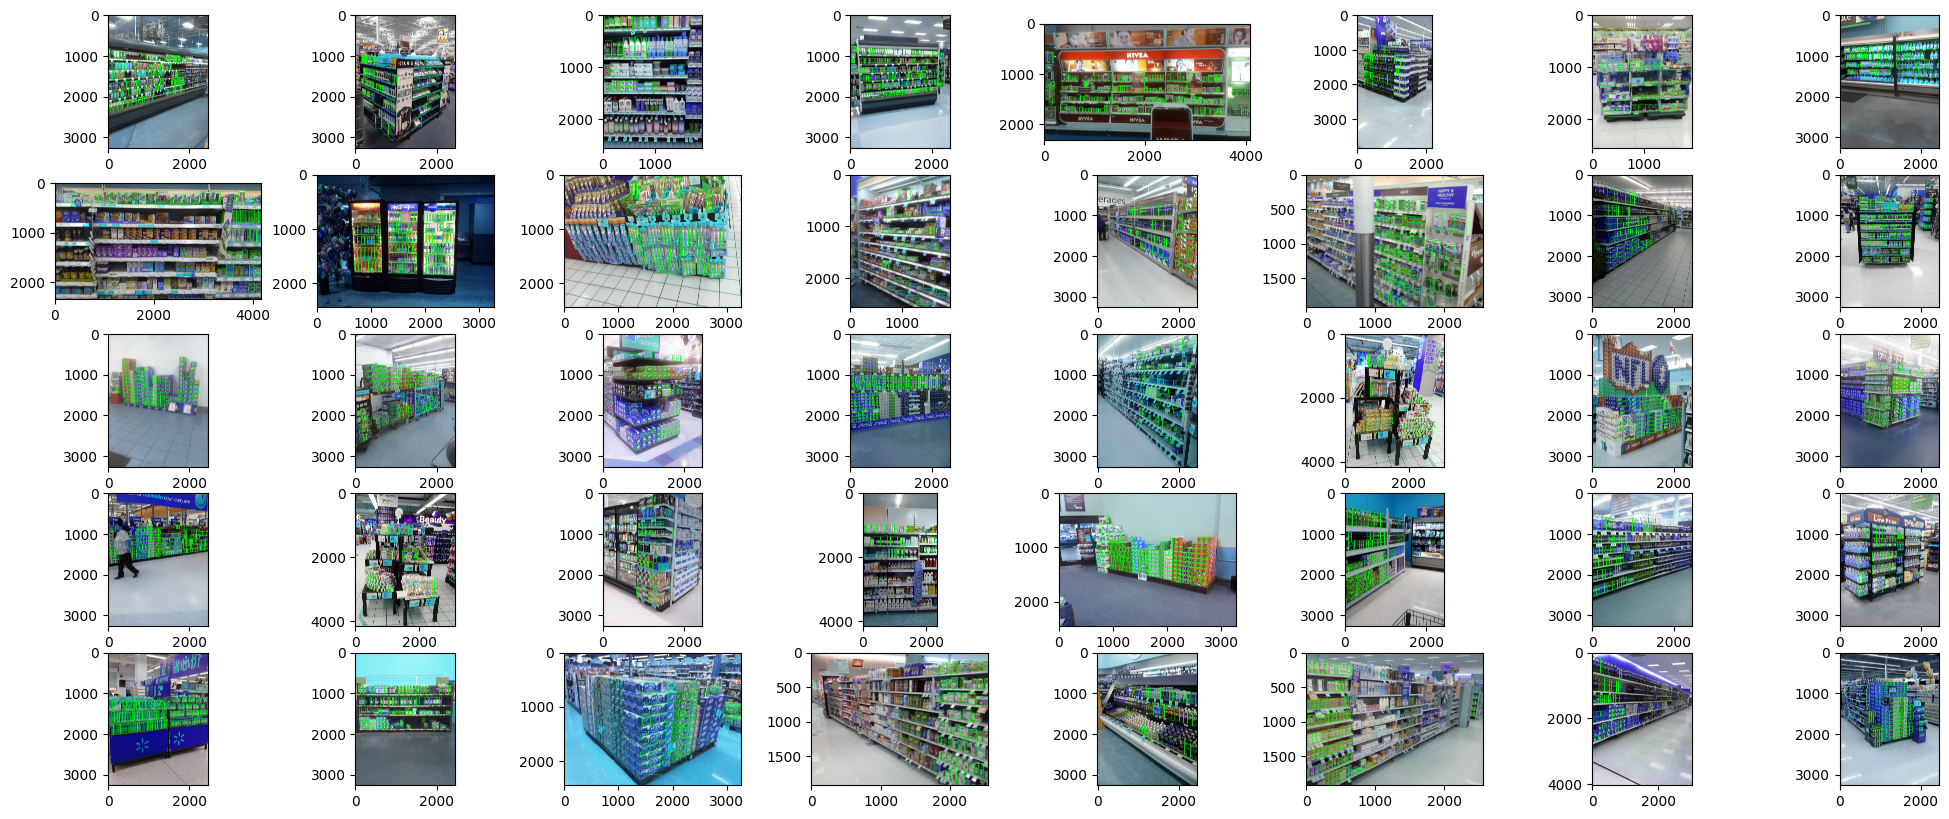

In [13]:
plot_failed_imgs(failed_tags_area,5,8)

> _We are going to directly discard these images from the dataset (some of them have really uggly view angles, some of them have only a few products tagged, etc). We implemented this in the `utils.remove_failed_imgs_from_data` function_

In [14]:
# delete the failed images from the dataframe
# tags_df.set_index('img_name', inplace = True)
tags_df_clean = tags_df.drop(failed_imgs1.index.to_list())
tags_df_clean

x1    y1    x2    y2    type  height  width  total_area  \
img_name                                                                   
train_0.jpg     208   537   422   814  object    3024   3024     9144576   
train_0.jpg    1268  1923  1365  2209  object    3024   3024     9144576   
train_0.jpg    1135  2074  1261  2166  object    3024   3024     9144576   
train_0.jpg    1045  2085  1122  2258  object    3024   3024     9144576   
train_0.jpg     976  2036  1040  2177  object    3024   3024     9144576   
...             ...   ...   ...   ...     ...     ...    ...         ...   
train_999.jpg   422  2386   675  2542  object    2336   4160     9717760   
train_999.jpg   427  2581   667  2715  object    2336   4160     9717760   
train_999.jpg   699  2365   823  2474  object    2336   4160     9717760   
train_999.jpg  1849  1678  2108  1769  object    2336   4160     9717760   
train_999.jpg   905  1589  1144  1712  object    2336   4160     9717760   

               bbox_area  bbox_area_perc  
img_name                                  
train_0.jpg        59278        0.006482  
train_0.jpg        27742        0.003034  
train_0.jpg        11592        0.001268  
train_0.jpg        13321        0.001457  
train_0.jpg         9024        0.000987  
...                  ...             ...  
train_999.jpg      39468        0.004061  
train_999.jpg      32160        0.003309  
train_999.jpg      13516        0.001391  
train_999.jpg      23569        0.002425  
train_999.jpg      29397        0.003025  

[1206703 rows x 10 columns]

In [19]:
failed_path = os.path.join( uf.IMG_PATH, 'failed_imgs.csv')
failed_tags_area.to_csv(failed_path)

### Corrupted images

There are some corrupted images in the dataset

Corrupt JPEG data: premature end of data segment


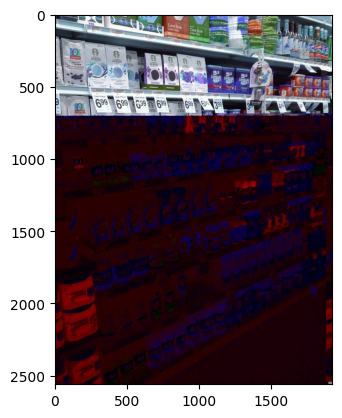

In [56]:
corr_path = '../data/train_test_SKU/train/train_1239.jpg'
corr_im = cv2.imread(corr_path)
plt.imshow(corr_im)

We used the 'bad_peggy' program (https://superuser.com/questions/276154/automating-the-scanning-of-graphics-files-for-corruption) to detect corrupted images. We stored that on a static csv:

In [66]:
bad_data_path = "../data/bad_data/corrupted_imgs.csv"
corr_csv = pd.read_csv(bad_data_path, index_col = 'img_name')
corr_csv

Reason
img_name                 
train_1239.jpg  Corrupted
train_2376.jpg  Corrupted
train_2903.jpg  Corrupted
train_2986.jpg  Corrupted
train_305.jpg   Corrupted
train_3240.jpg  Corrupted
train_340.jpg   Corrupted
train_3556.jpg  Corrupted
train_3560.jpg  Corrupted
train_38.jpg    Corrupted
train_3832.jpg  Corrupted
train_4222.jpg  Corrupted
train_5007.jpg  Corrupted
train_5137.jpg  Corrupted
train_5143.jpg  Corrupted
train_5762.jpg  Corrupted
train_5822.jpg  Corrupted
train_6052.jpg  Corrupted
train_6090.jpg  Corrupted
train_6138.jpg  Corrupted
train_6409.jpg  Corrupted
train_6722.jpg  Corrupted
train_6788.jpg  Corrupted
train_737.jpg   Corrupted
train_7576.jpg  Corrupted
train_7622.jpg  Corrupted
train_775.jpg   Corrupted
train_7883.jpg  Corrupted
train_789.jpg   Corrupted
train_8020.jpg  Corrupted
train_8146.jpg  Corrupted
train_882.jpg   Corrupted
train_903.jpg   Corrupted
train_924.jpg   Corrupted

#### Image metadata

We will analyze the following variables in this section:
* Image sizes

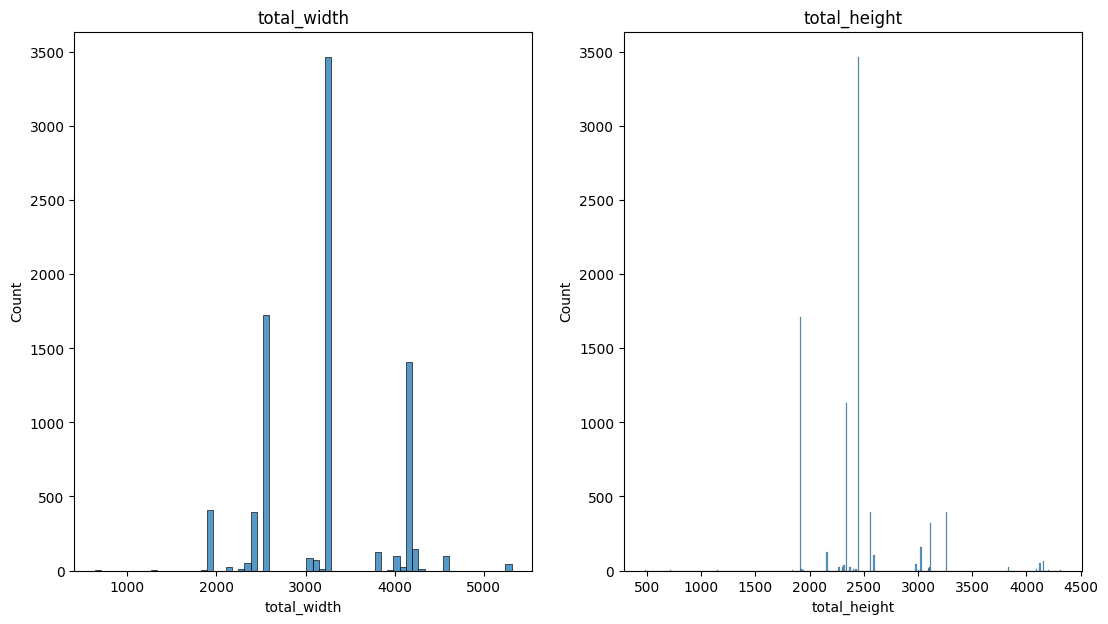

In [16]:
fig, axis = plt.subplots(1,2, figsize = (13,7))
vars = ['total_width', 'total_height']
unique_tags_df = tags_df.reset_index()
unique_tags_df.drop_duplicates(subset = ['img_name'] , inplace = True )

for var,ax in zip(vars,axis):
    sns.histplot(unique_tags_df[var], ax = ax)
    ax.set(title = var)

In [13]:
tags_df..resdrop_duplicates(subset)

x1    y1    x2    y2    type  total_height  total_width
img_name                                                                
train_0.jpg     208   537   422   814  object          3024         3024
train_0.jpg    1268  1923  1365  2209  object          3024         3024
train_0.jpg    1135  2074  1261  2166  object          3024         3024
train_0.jpg    1045  2085  1122  2258  object          3024         3024
train_0.jpg     976  2036  1040  2177  object          3024         3024
...             ...   ...   ...   ...     ...           ...          ...
train_999.jpg   422  2386   675  2542  object          2336         4160
train_999.jpg   427  2581   667  2715  object          2336         4160
train_999.jpg   699  2365   823  2474  object          2336         4160
train_999.jpg  1849  1678  2108  1769  object          2336         4160
train_999.jpg   905  1589  1144  1712  object          2336         4160

[1208478 rows x 7 columns]